In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Kaustade nimed ja klasside määramine
class_names = ["COVID19", "NORMAL", "PNEUMONIA", "TURBERCULOSIS"]
image_data = []
labels = []
# Andmete laadimine
for idx, class_name in enumerate(class_names):
    folder_path = f"Chest X_Ray Dataset/{class_name}"
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_data.append(img)
        labels.append(idx)  # Määrake klassi indeks

In [2]:
# Muuda andmed numpy massiivideks
image_data = np.array(image_data)
labels = np.array(labels)
# Andmete jaotamine treening-, valideerimis- ja testikomplektideks
X_train, X_test, y_train, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42
)
X_train = X_train / 255.0
X_test = X_test / 255.0

In [3]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
datagen.fit(X_train)

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Kasuta eelnevalt treenitud ResNet50 mudelit
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Ära treeni eelnevalt treenitud kihti

In [ ]:
# Täiendame mudelit
model = models.Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
# Treenime mudelit
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=3,  # mingi 10 minimum äkki sobiks
)

Epoch 1/3


/opt/homebrew/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1427/1427 ━━━━━━━━━━━━━━━━━━━━ 258s 179ms/step - accuracy: 0.5942 - loss: 1.0869 - val_accuracy: 0.5851 - val_loss: 1.0523
Epoch 2/3
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 269s 188ms/step - accuracy: 0.6156 - loss: 0.9940 - val_accuracy: 0.6720 - val_loss: 1.0553
Epoch 3/3
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 281s 197ms/step - accuracy: 0.6297 - loss: 0.9614 - val_accuracy: 0.6251 - val_loss: 0.9091


In [7]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step
[[  0   6 127   0]
 [  0  86 231   0]
 [  0  29 806   0]
 [  0  14 128   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.64      0.27      0.38       317
           2       0.62      0.97      0.76       835
           3       0.00      0.00      0.00       142

    accuracy                           0.63      1427
   macro avg       0.32      0.31      0.28      1427
weighted avg       0.51      0.63      0.53      1427



/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
results = model.evaluate(X_test, y_test, batch_size=8)
print(model.metrics_names)  # Kuvab saadavalolevate mõõdikute nimed
print(results)

179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 302ms/step - accuracy: 0.6174 - loss: 0.9134
['loss', 'compile_metrics']
[0.9090782999992371, 0.6250876188278198]


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


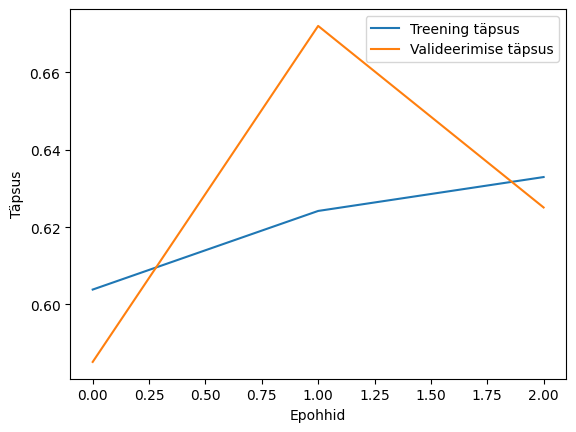

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())  #
plt.plot(history.history["accuracy"], label="Treening täpsus")
plt.plot(history.history["val_accuracy"], label="Valideerimise täpsus")
plt.xlabel("Epohhid")
plt.ylabel("Täpsus")
plt.legend()
plt.show()

In [16]:
print(f"accuracy: {history.history['val_accuracy']}")
print(f"accuracy: {history.history['accuracy']}")

accuracy: [0.5851436853408813, 0.672039270401001, 0.6250876188278198]
accuracy: [0.6038562655448914, 0.6241893172264099, 0.6329535245895386]


<h1>uute piltide testimine<h1>


In [55]:
import tensorflow as tf

new_images_path = "uued"

# Kategooriate nimed
categories = ["COVID19", "TUBERCOLOSIS", "NORMAL"]

# Laadime uued pildid
new_images = []
for img_name in os.listdir(new_images_path):
    img_path = os.path.join(new_images_path, img_name)

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    new_images.append(img_array)

# Muudame uued pildid numpy massiiviks
new_images = np.array(new_images)

# Normaliseerime pildid, et need oleksid vahemikus [0, 1]
new_images = new_images / 255.0

# Ennustamine uute piltide kohta
predictions = model.predict(new_images)

# Kuvame tulemused
for i, prediction in enumerate(predictions):
    predicted_class = np.argmax(prediction)  # Kõrgeima tõenäosusega klass
    print(
        f"Pilt {i+1}: Ennustus: {categories[predicted_class]}, Tõenäosus: {prediction[predicted_class]:.2f}"
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Pilt 1: Ennustus: NORMAL, Tõenäosus: 0.71
Pilt 2: Ennustus: NORMAL, Tõenäosus: 0.55
Pilt 3: Ennustus: NORMAL, Tõenäosus: 0.76
Pilt 4: Ennustus: NORMAL, Tõenäosus: 0.74


In [56]:
from tensorflow.keras.utils import image_dataset_from_directory

# Lae testandmestik
test_dataset = image_dataset_from_directory(
    "Chest X_Ray Dataset",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
)

# Hindamine mudeliga
loss, accuracy = model.evaluate(test_dataset)
print(f"Testandmete täpsus: {accuracy:.2f}")

Found 7132 files belonging to 4 classes.
 20/223 ━━━━━━━━━━━━━━━━━━━━ 2:32 753ms/step - accuracy: 0.0999 - loss: 37.5505

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


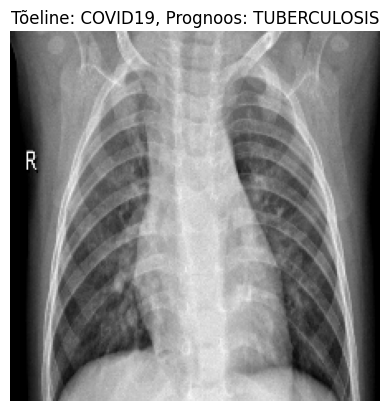

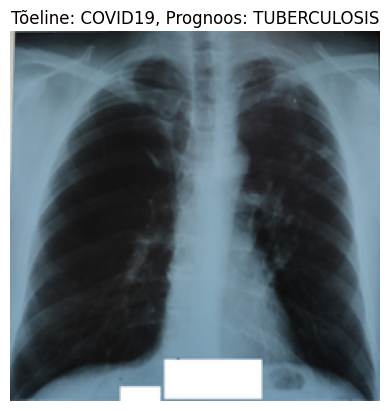

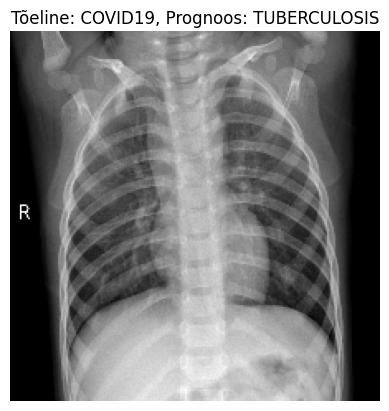

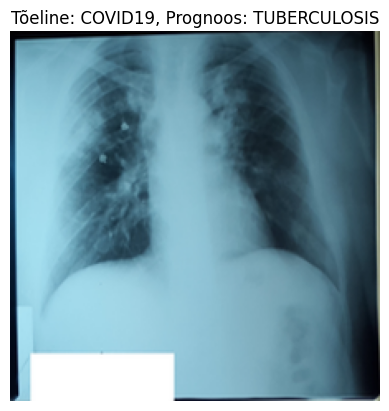

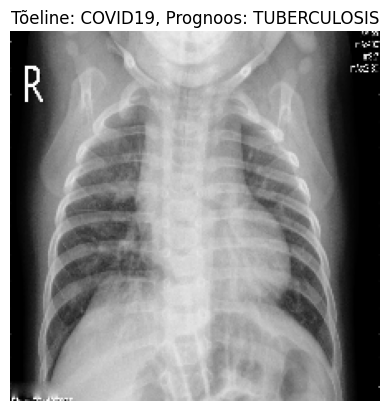

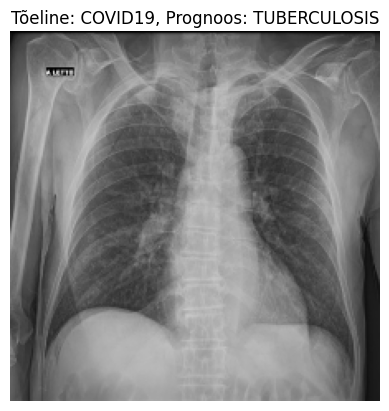

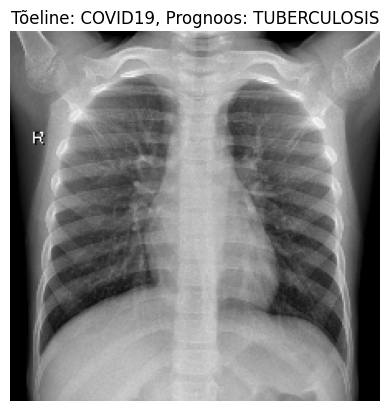

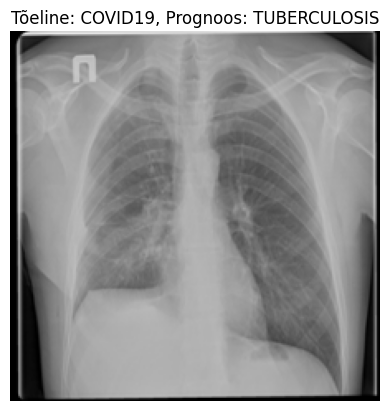

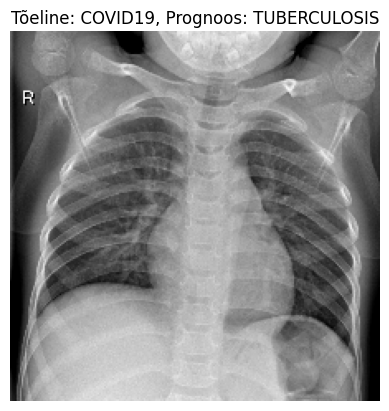

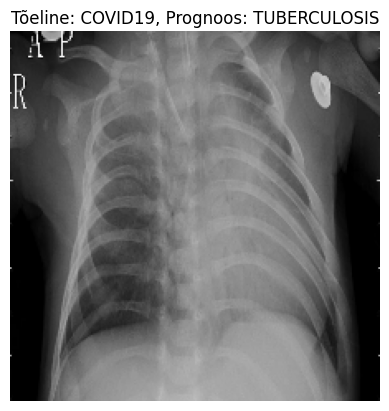

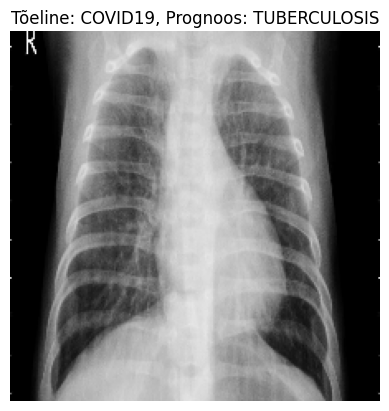

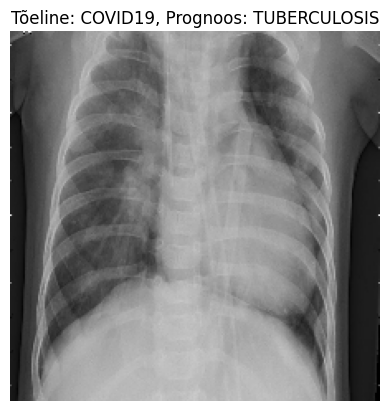

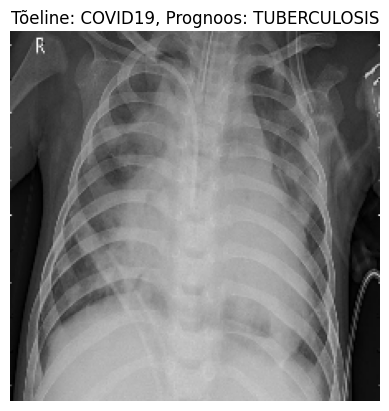

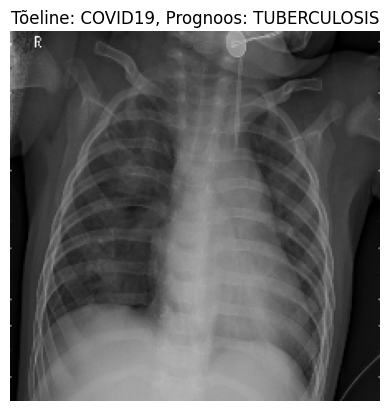

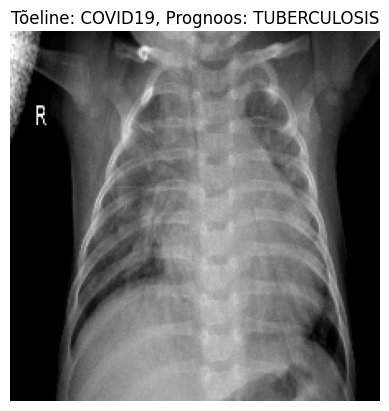

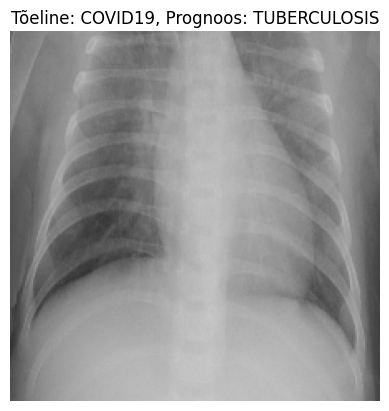

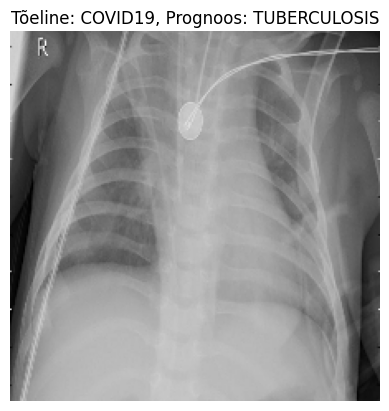

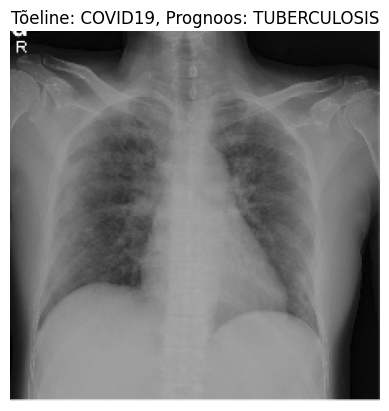

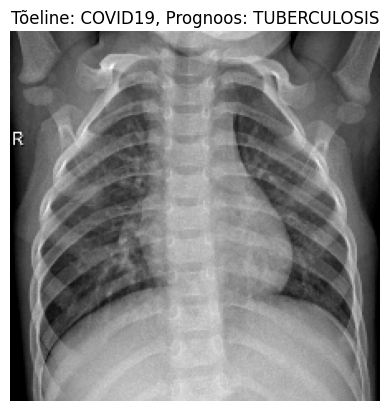

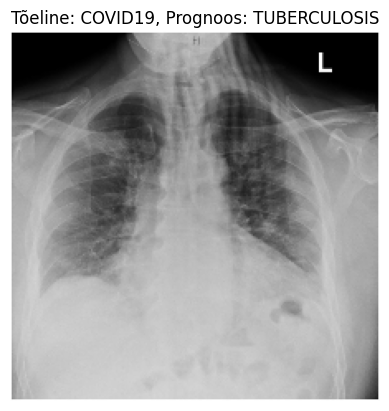

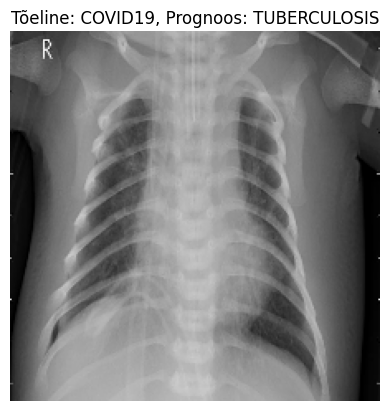

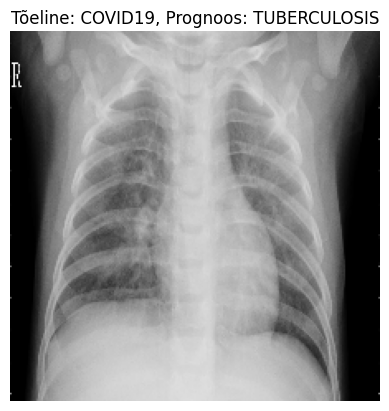

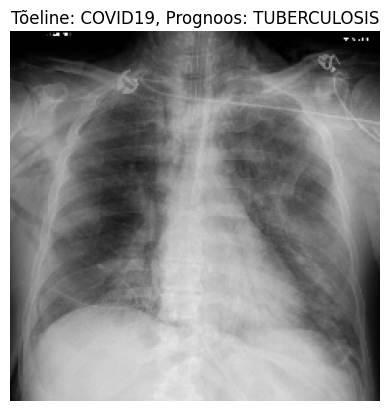

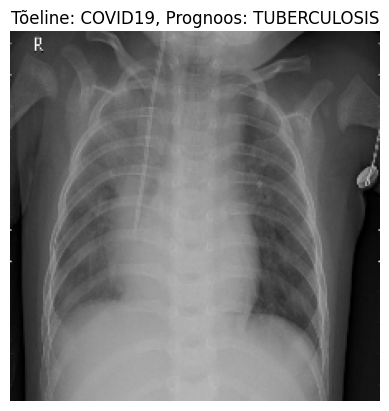

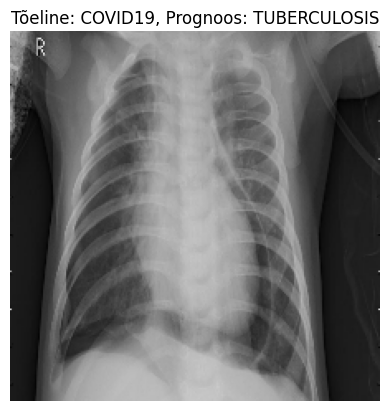

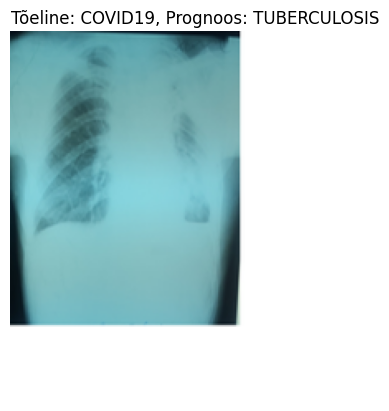

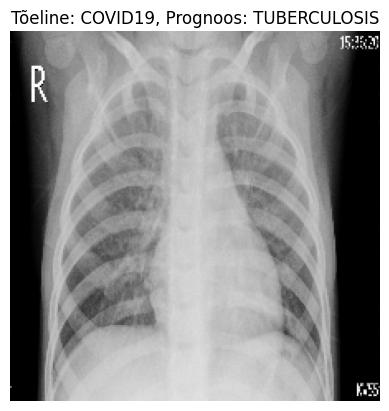

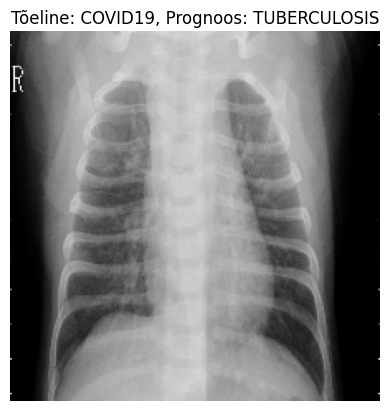

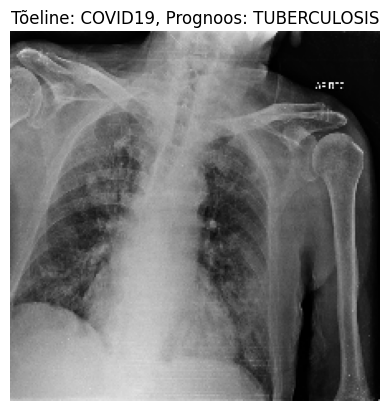

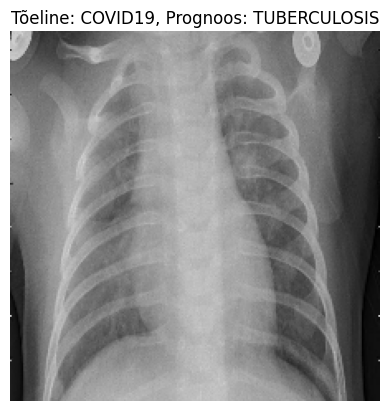

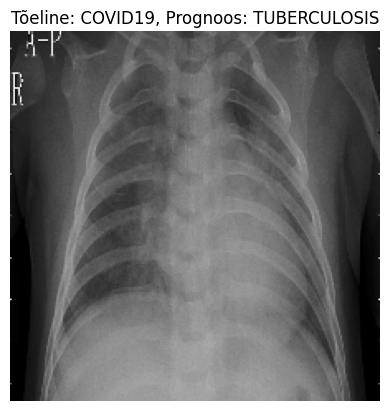

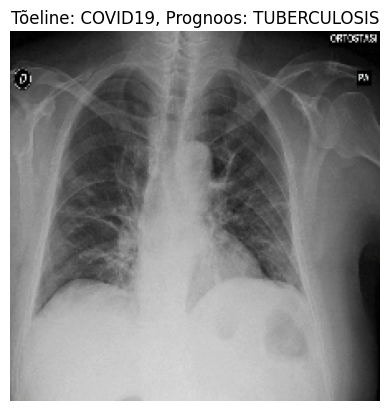

2024-11-28 00:32:27.158448: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [52]:
import matplotlib.pyplot as plt

for images, labels in test_dataset.take(1):  # Võta esimene partii testandmeid
    predictions = model.predict(images)
    for i in range(len(images)):
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = classes[np.argmax(predictions[i])]
        true_class = classes[np.argmax(labels[i].numpy())]
        plt.title(f"Tõeline: {true_class}, Prognoos: {predicted_class}")
        plt.axis("off")
        plt.show()